# Skin Cancer Classification
Note: The files used here are not attached to this repository.

In [111]:
# Load libraries
!pip install imblearn keras-tuner opencv-python
from tensorflow import keras
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout, GlobalAveragePooling2D, BatchNormalization
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import random
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters as hp
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score, classification_report, roc_auc_score
from keras_tuner import Objective
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import cv2

print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

%matplotlib inline

Num GPUs Available:  1


# Constants

In [2]:
# Change this when you are running this yourself.
IMAGE_PATH = "/home/jovyan/work/ai/train"
OUTPUT_IMAGE_PATH_DOCKER = "/home/jovyan/work/tmp"
KERAS_IMAGE_CONFIG = (128, 128, 1) # 128 x 128, greyscale (1 channel) (or 256x256 RGB)
KERAS_BATCH_SIZE = 16
IMAGE_FILENAME_COLUMN = "image_name"
LESION_STATUS_COLUMN = "benign_malignant"
CLASS_MODE = "binary"
COLOUR_MODE = "grayscale"
TRUTH_FILE = "/home/jovyan/work/ai/ISIC_2020_Training_GroundTruth_v2.csv"
ANATOMY_SITE_COLUMN = "anatom_site_general_challenge"
CANCEROUS = "malignant"
NON_CANCEROUS = "benign"

In [3]:
training_ground_truth = pd.read_csv(TRUTH_FILE)

# Data Preparation

In [4]:
# Null values
training_ground_truth.dropna(inplace=True)

In [5]:
# Add the `.jpg` extension
training_ground_truth[IMAGE_FILENAME_COLUMN] = training_ground_truth[IMAGE_FILENAME_COLUMN].apply(lambda x: f"{x}.jpg")

In [6]:
# Extract the target
training_ground_truth_y = training_ground_truth[LESION_STATUS_COLUMN]
training_ground_truth.drop(LESION_STATUS_COLUMN, axis=1, inplace=True)

In [7]:
# In this case we remove some columns as well
# benign_malignant is the same as target.

# I think the `diagnosis` feature can be dropped as well.

training_ground_truth.drop(["patient_id", "lesion_id", "target", "diagnosis"], axis=1, inplace=True)

In [8]:
# Hot-Encode the site feature
# Normal encoding not used as it could introduce unwanted relationships unintentionally

anatom_options = training_ground_truth[ANATOMY_SITE_COLUMN].unique()

nested_options = [[option] for option in anatom_options]

# Convert the anatom site to an array [x, y, z, ... ]
hot_encoded_anatom_site = pd.get_dummies(training_ground_truth[ANATOMY_SITE_COLUMN], prefix="anatom_site")
# Some anatom_site has a / or a space character. Replace it for consistency.
hot_encoded_anatom_site = hot_encoded_anatom_site.rename(columns=lambda x: x.replace('/', '_').replace(' ', '_'))

# Replace the original feature
training_ground_truth = pd.concat([training_ground_truth.drop(ANATOMY_SITE_COLUMN, axis=1), hot_encoded_anatom_site], axis=1)

In [9]:
training_ground_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32531 entries, 0 to 33125
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   image_name                   32531 non-null  object 
 1   sex                          32531 non-null  object 
 2   age_approx                   32531 non-null  float64
 3   anatom_site_head_neck        32531 non-null  bool   
 4   anatom_site_lower_extremity  32531 non-null  bool   
 5   anatom_site_oral_genital     32531 non-null  bool   
 6   anatom_site_palms_soles      32531 non-null  bool   
 7   anatom_site_torso            32531 non-null  bool   
 8   anatom_site_upper_extremity  32531 non-null  bool   
dtypes: bool(6), float64(1), object(2)
memory usage: 1.2+ MB


In [10]:
training_ground_truth_y.info()

<class 'pandas.core.series.Series'>
Index: 32531 entries, 0 to 33125
Series name: benign_malignant
Non-Null Count  Dtype 
--------------  ----- 
32531 non-null  object
dtypes: object(1)
memory usage: 508.3+ KB


# More Data Exploration Post-Cleaning

In [11]:
# Undersampling
# Balanced
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=random.randint(0, 2**32 - 1))

undersampled_x, undersampled_y = undersampler.fit_resample(training_ground_truth, training_ground_truth_y)

In [12]:
undersampled_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   image_name                   1150 non-null   object 
 1   sex                          1150 non-null   object 
 2   age_approx                   1150 non-null   float64
 3   anatom_site_head_neck        1150 non-null   bool   
 4   anatom_site_lower_extremity  1150 non-null   bool   
 5   anatom_site_oral_genital     1150 non-null   bool   
 6   anatom_site_palms_soles      1150 non-null   bool   
 7   anatom_site_torso            1150 non-null   bool   
 8   anatom_site_upper_extremity  1150 non-null   bool   
dtypes: bool(6), float64(1), object(2)
memory usage: 33.8+ KB


In [13]:
undersampled_y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1150 entries, 0 to 1149
Series name: benign_malignant
Non-Null Count  Dtype 
--------------  ----- 
1150 non-null   object
dtypes: object(1)
memory usage: 9.1+ KB


In [14]:
# Split into training and validation. The testing dataset is provided separately under "./testing" (or "./test"?)
# However, let's also split the training test further into train_df and temp_test_df. Maybe.

# concatenate the variables and labels
undersampled_df = pd.concat([undersampled_x, undersampled_y], axis=1)

train_df, validate_df = train_test_split(undersampled_df, test_size=0.2, random_state=random.randint(0, 2**32 - 1), stratify=undersampled_df[LESION_STATUS_COLUMN])

train_df, test_df = train_test_split(train_df, test_size=0.2 / (0.6 + 0.2), random_state=random.randint(0, 2**32 - 1), stratify=train_df[LESION_STATUS_COLUMN])

print("Train, validate and test (the actual testing happens later) lengths:")
print(len(train_df))
print(len(validate_df))
print(len(test_df))

Train, validate and test (the actual testing happens later) lengths:
690
230
230


## Docker - Image Copying

In [15]:
import shutil
import os

def copy_images(df):
    src_dir = IMAGE_PATH
    dst_dir = OUTPUT_IMAGE_PATH_DOCKER
    
    # Check if the destination directory exists; if not, create it
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)

    for index, row in df.iterrows():
        image_name_to_copy = row[IMAGE_FILENAME_COLUMN]
        src_path = os.path.join(src_dir, image_name_to_copy)
        dst_path = os.path.join(dst_dir, image_name_to_copy)

        shutil.copy(src_path, dst_path)

# If in Docker:
# Change this if you are not running in Docker.
in_docker = True

if in_docker:
    copy_images(train_df)
    copy_images(validate_df)
    copy_images(test_df)
    IMAGE_PATH = OUTPUT_IMAGE_PATH_DOCKER

# Image Loading From Disk

In [16]:
# Note: Do not perform random transformations on the validation or testing set.
def load_images(df, transformations):
    image_data_generator = ImageDataGenerator(rotation_range=360)
    
    temp_images = []
    
    for index, row in df.iterrows():
        image_name = row[IMAGE_FILENAME_COLUMN]
        temp_image = image.load_img(os.path.join(IMAGE_PATH, image_name), target_size=(KERAS_IMAGE_CONFIG[0], KERAS_IMAGE_CONFIG[1]), color_mode=COLOUR_MODE)
        temp_image_array = image.img_to_array(temp_image) / 255.0 # Normalising the image pixels
        
        if transformations:
            temp_image_array = image_data_generator.random_transform(temp_image_array)
        
        temp_images.append(temp_image_array)
    
    return temp_images

In [17]:
train_images = load_images(train_df, True)
train_labels = [1 if original_label == CANCEROUS else 0 for original_label in train_df[LESION_STATUS_COLUMN]]

validation_images = load_images(validate_df, False)
validation_labels = [1 if original_label == CANCEROUS else 0 for original_label in validate_df[LESION_STATUS_COLUMN]]

test_images = load_images(test_df, False)
test_labels = [1 if original_label == CANCEROUS else 0 for original_label in test_df[LESION_STATUS_COLUMN]]

In [18]:
print(len(train_images))
print(len(train_labels))

print(len(validation_images))
print(len(validation_labels))

print(len(test_images))
print(len(test_labels))

690
690
230
230
230
230


# Model Creation

In [19]:
def print_confusion_matrix(true_labels, predictions):
    temp_confusion_matrix = confusion_matrix(true_labels, predictions)
    
    # Calculate what percentage each class is equal to.
    temp_percentages = temp_confusion_matrix.astype("float") / temp_confusion_matrix.sum(axis=1)[:, np.newaxis]
    temp_percentages = np.round(temp_percentages * 100, 2) # Round to 2 decimal places
    
    # Also, as seaborn doesn't include the values by default, we need to add them
    confusion_matrix_labels = [["True Negative\n{}\n{}%".format(temp_confusion_matrix[0, 0], temp_percentages[0, 0]),
                                "False Positive\n{}\n{}%".format(temp_confusion_matrix[0, 1], temp_percentages[0, 1])],
                               ["False Negative\n{}\n{}%".format(temp_confusion_matrix[1, 0], temp_percentages[1, 0]),
                                "True Positive\n{}\n{}%".format(temp_confusion_matrix[1, 1], temp_percentages[1, 1])]]
    
    plt.figure(figsize=(6, 6))
    
    # Use Seaborn so we can add annotations
    sns.heatmap(temp_confusion_matrix, annot=confusion_matrix_labels, fmt="", cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [20]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        f1_score = 2 * ((precision * recall) / (precision + recall + 1e-7)) # Prevent division by zero.
        return f1_score

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

## CNN - No Hyper-Parameters

In [21]:
# No hyper-parameters, following what `Introduction to convolutional neural network using Keras; an understanding from a statistician` did

initial_model = Sequential([
    Conv2D(filters=32,
           kernel_size=(3,3),
           activation="relu",
           input_shape=KERAS_IMAGE_CONFIG),
    Conv2D(filters=64,
           kernel_size=(3,3),
           activation="relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(units=128, activation="relu"),
    Dropout(0.5),
    Dense(units=1, activation="sigmoid")
])

2023-04-12 03:17:00.342396: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 03:17:00.343865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 03:17:00.344343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-12 03:17:00.344771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [22]:
initial_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [23]:
print(initial_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 128)               31490176  
                                                        

In [24]:
# Train
epochs = 30
initial_train_data_gen = ImageDataGenerator(rotation_range=360) # no normalising here as that has already been done when loading the images from disk into memory
initial_train_generator = initial_train_data_gen.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)

initial_history = initial_model.fit(initial_train_generator, validation_data=(np.array(validation_images), np.array(validation_labels)), epochs=epochs)

Epoch 1/30


2023-04-12 03:17:02.629561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


44/44 [==============================] - 4s 50ms/step - loss: 1.0509 - auc: 0.5179 - val_loss: 0.6930 - val_auc: 0.5044
Epoch 2/30
44/44 [==============================] - 2s 41ms/step - loss: 0.6895 - auc: 0.5397 - val_loss: 0.6747 - val_auc: 0.6940
Epoch 3/30
44/44 [==============================] - 2s 41ms/step - loss: 0.6804 - auc: 0.6636 - val_loss: 0.6663 - val_auc: 0.7403
Epoch 4/30
44/44 [==============================] - 2s 42ms/step - loss: 0.6753 - auc: 0.6410 - val_loss: 0.6635 - val_auc: 0.7112
Epoch 5/30
44/44 [==============================] - 2s 42ms/step - loss: 0.6769 - auc: 0.6416 - val_loss: 0.6726 - val_auc: 0.6077
Epoch 6/30
44/44 [==============================] - 2s 40ms/step - loss: 0.6852 - auc: 0.6151 - val_loss: 0.6823 - val_auc: 0.7236
Epoch 7/30
44/44 [==============================] - 2s 41ms/step - loss: 0.6759 - auc: 0.5927 - val_loss: 0.6612 - val_auc: 0.6141
Epoch 8/30
44/44 [==============================] - 2s 41ms/step - loss: 0.6576 - auc: 0.6716 

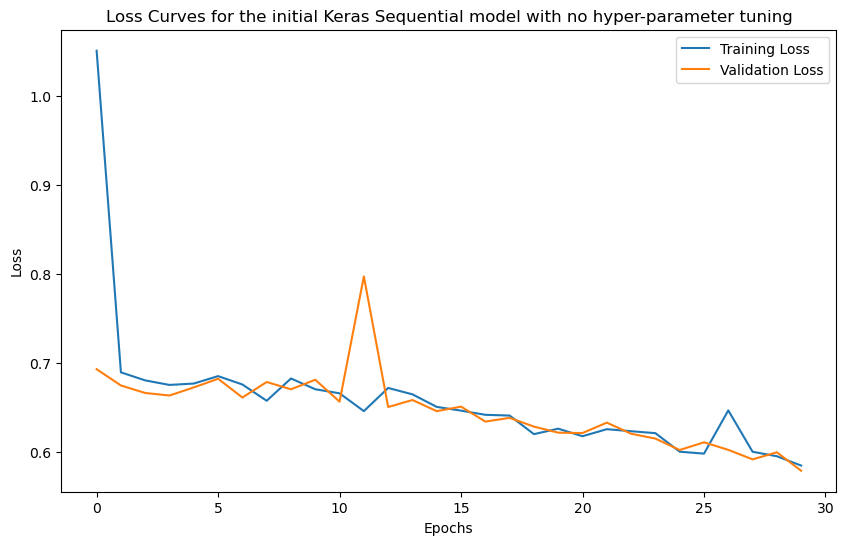

In [25]:
# Plot the loss curves for the initial model without hyper parameter tuning
plt.figure(figsize=(10, 6))

# Plot the loss curves

initial_training_loss = initial_history.history["loss"]
initial_validation_loss = initial_history.history["val_loss"]

plt.plot(initial_training_loss, label="Training Loss")
plt.plot(initial_validation_loss, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for the initial Keras Sequential model with no hyper-parameter tuning")
plt.legend()

plt.show()

In [26]:
# Make predictions using the initial model using the testing dataset
initial_model_predictions = initial_model.predict(np.array(test_images))
initial_model_prediction_labels = np.round(initial_model_predictions)

8/8 [==============================] - 0s 13ms/step


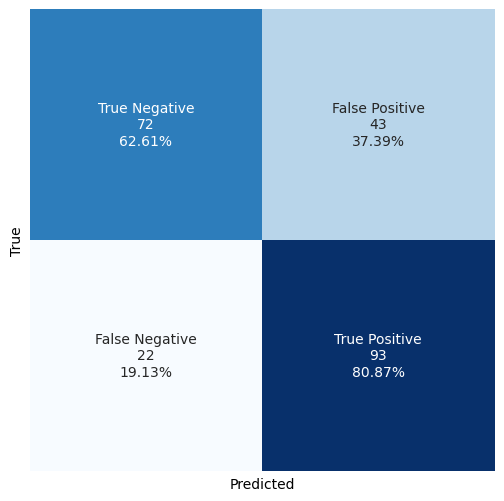

In [27]:
# Confusion Matrix
print_confusion_matrix(test_labels, initial_model_prediction_labels)

In [28]:
# Classification report
initial_classification_report = classification_report(test_labels, initial_model_prediction_labels)
print(initial_classification_report)

              precision    recall  f1-score   support

           0       0.77      0.63      0.69       115
           1       0.68      0.81      0.74       115

    accuracy                           0.72       230
   macro avg       0.72      0.72      0.72       230
weighted avg       0.72      0.72      0.72       230



In [65]:
# I'm happy with this model, so let's save it
initial_model.save("./initial_model.h5")

## Adjusted Initial Model

In [53]:
adjusted_model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=KERAS_IMAGE_CONFIG),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(1, activation="sigmoid")
])

In [54]:
adjusted_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [55]:
print(adjusted_model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 batch_normalization_15 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_16 (Bat  (None, 61, 61, 64)       256       
 chNormalization)                                                
                                                      

In [56]:
# Train
adjusted_epochs = 50

adjusted_train_data_gen = ImageDataGenerator(rotation_range=360) # no normalising here as that has already been done when loading the images from disk into memory
adjusted_train_generator = adjusted_train_data_gen.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)

adjusted_history = adjusted_model.fit(adjusted_train_generator, validation_data=(np.array(validation_images), np.array(validation_labels)), epochs=adjusted_epochs)

Epoch 1/50
44/44 [==============================] - 2s 30ms/step - loss: 0.8487 - auc_4: 0.6621 - val_loss: 0.7401 - val_auc_4: 0.7431
Epoch 2/50
44/44 [==============================] - 1s 23ms/step - loss: 0.6974 - auc_4: 0.7241 - val_loss: 0.8212 - val_auc_4: 0.6799
Epoch 3/50
44/44 [==============================] - 1s 23ms/step - loss: 0.7299 - auc_4: 0.7097 - val_loss: 0.6422 - val_auc_4: 0.7478
Epoch 4/50
44/44 [==============================] - 1s 23ms/step - loss: 0.6788 - auc_4: 0.7144 - val_loss: 0.7035 - val_auc_4: 0.6868
Epoch 5/50
44/44 [==============================] - 1s 22ms/step - loss: 0.6610 - auc_4: 0.7274 - val_loss: 0.7782 - val_auc_4: 0.6762
Epoch 6/50
44/44 [==============================] - 1s 22ms/step - loss: 0.7207 - auc_4: 0.6898 - val_loss: 0.7230 - val_auc_4: 0.7507
Epoch 7/50
44/44 [==============================] - 1s 22ms/step - loss: 0.6728 - auc_4: 0.7152 - val_loss: 0.7357 - val_auc_4: 0.4406
Epoch 8/50
44/44 [==============================] - 1s 

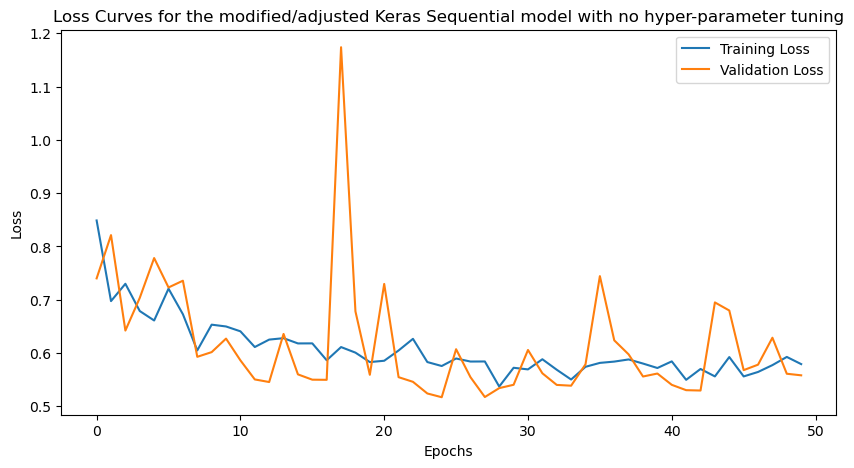

In [57]:
# Plot the loss curves for the initial model without hyper parameter tuning
plt.figure(figsize=(10, 5))

# Plot the loss curves

adjusted_training_loss = adjusted_history.history["loss"]
adjusted_validation_loss = adjusted_history.history["val_loss"]

plt.plot(adjusted_training_loss, label="Training Loss")
plt.plot(adjusted_validation_loss, label="Validation Loss")

# Set the labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for the modified/adjusted Keras Sequential model with no hyper-parameter tuning")
plt.legend()

# Display the plot
plt.show()

In [58]:
# Make predictions using the adjusted model using the testing dataset
adjusted_model_predictions = adjusted_model.predict(np.array(test_images))
adjusted_model_prediction_labels = np.round(adjusted_model_predictions)


8/8 [==============================] - 0s 8ms/step


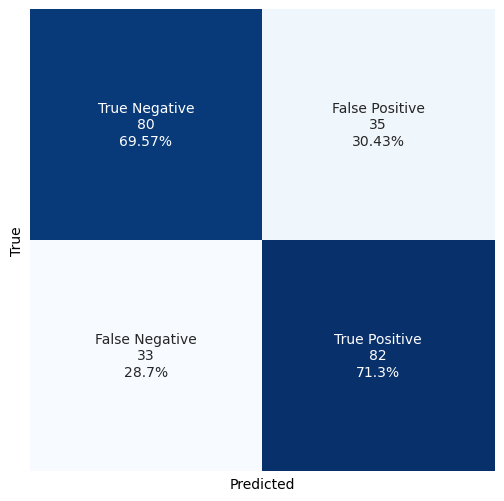

In [59]:
# Confusion Matrix
print_confusion_matrix(test_labels, adjusted_model_prediction_labels)

In [60]:
# Classification report
adjusted_classification_report = classification_report(test_labels, adjusted_model_prediction_labels)
print(adjusted_classification_report)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       115
           1       0.70      0.71      0.71       115

    accuracy                           0.70       230
   macro avg       0.70      0.70      0.70       230
weighted avg       0.70      0.70      0.70       230



In [63]:
# I'm happy with this model, so let's save it
adjusted_model.save("./adjusted_model.h5")

## CNN - Hyper-Parameters

In [68]:
def build_model(hyper_params):
    hyper_model = Sequential()
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_1_filter", min_value=16, max_value=64, step=16),
                           kernel_size=hyper_params.Choice(name="conv_1_kernel", values=[3,5]),
                           activation="relu",
                           input_shape=KERAS_IMAGE_CONFIG)
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_1_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_2_filter", min_value=32, max_value=64, step=16),
                           kernel_size=hyper_params.Choice(name="conv_2_kernel", values=[3,5]),
                           activation="relu",
                          )
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_2_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Conv2D(filters=hyper_params.Int(name="conv_3_filter", min_value=64, max_value=128, step=32),
                           kernel_size=hyper_params.Choice(name="conv_3_kernel", values=[3,5]),
                           activation="relu",
                          )
                   )
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(MaxPooling2D(pool_size=hyper_params.Int(name="pool_3_size", min_value=2, max_value=4, step=1)))
    
    hyper_model.add(Flatten())
    
    hyper_model.add(Dense(units=hyper_params.Int(name="dense_1_units", min_value=64, max_value=256, step=64), activation="relu"))
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(Dropout(hyper_params.Float(name="dropout_1_rate", min_value=0.1, max_value=0.5, step=0.1)))
    
    hyper_model.add(Dense(units=hyper_params.Int(name="dense_2_units", min_value=64, max_value=128, step=32), activation="relu"))
    
    hyper_model.add(BatchNormalization())
    
    hyper_model.add(Dropout(hyper_params.Float(name="dropout_2_rate", min_value=0.1, max_value=0.5, step=0.1)))
    
    hyper_model.add(Dense(units=1, activation="sigmoid"))
    
    hyper_model.compile(optimizer=Adam(hyper_params.Choice(name="learning_rate", values=[1e-2, 1e-3, 1e-4])),
                  loss="binary_crossentropy",
                  metrics=[tf.keras.metrics.AUC()])
    
    return hyper_model

In [69]:
hyper_tuner = RandomSearch(
    build_model,
    objective=Objective("val_auc", direction="max"), # Pontentially change this into a weighted sum of auc and f1
    max_trials=10,
    executions_per_trial=10,
    directory="./keras_tuner",
    project_name="sequential_hyper_params")

In [70]:
hyper_tuner.search_space_summary()

Search space summary
Default search space size: 14
conv_1_filter (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_1_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_2_filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_2_size (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_3_filter (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
pool_3_size (Int)
{'default': None, 'conditions': [], 'min_value'

In [71]:
# Search for Hyper-Params
hyper_epochs = 20

hyper_train_data_gen = ImageDataGenerator(rotation_range=360) # no normalising here as that has already been done when loading the images from disk into memory
hyper_train_generator = hyper_train_data_gen.flow(np.array(train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)

hyper_tuner.search(hyper_train_generator, epochs=hyper_epochs, validation_data=(np.array(validation_images), np.array(validation_labels)))

Trial 10 Complete [00h 03m 24s]
val_auc: 0.7786616325378418

Best val_auc So Far: 0.8016748487949371
Total elapsed time: 00h 33m 50s
INFO:tensorflow:Oracle triggered exit


In [72]:
best_hyper_model = hyper_tuner.get_best_models(num_models=1)[0]
best_hyper_parameters = hyper_tuner.get_best_hyperparameters(num_trials=1)[0]

In [79]:
print("Best Hyper Parameters for the Keras Sequential model:")
for k, v in best_hyper_parameters.values.items():
    print(f"{k}\t: {v}")

Best Hyper Parameters for the Keras Sequential model:
conv_1_filter	: 16
conv_1_kernel	: 5
pool_1_size	: 3
conv_2_filter	: 48
conv_2_kernel	: 3
pool_2_size	: 2
conv_3_filter	: 128
conv_3_kernel	: 3
pool_3_size	: 4
dense_1_units	: 256
dropout_1_rate	: 0.2
dense_2_units	: 64
dropout_2_rate	: 0.2
learning_rate	: 0.0001


In [80]:
# Make predictions using the adjusted model using the testing dataset
best_hyper_model_predictions = best_hyper_model.predict(np.array(test_images))
best_hyper_model_prediction_labels = np.round(best_hyper_model_predictions)

8/8 [==============================] - 0s 5ms/step


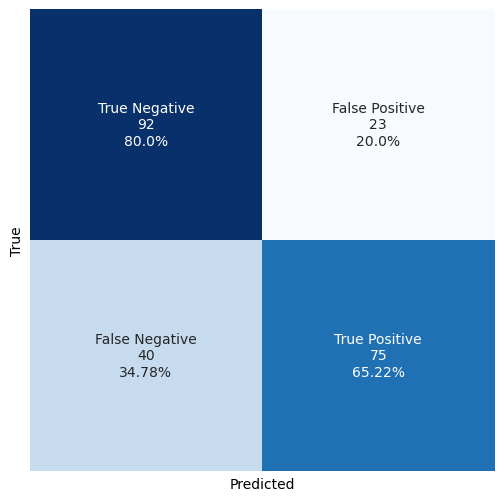

In [81]:
# Confusion Matrix
print_confusion_matrix(test_labels, best_hyper_model_prediction_labels)

In [82]:
# Classification report
best_hyper_classification_report = classification_report(test_labels, best_hyper_model_prediction_labels)
print(best_hyper_classification_report)

              precision    recall  f1-score   support

           0       0.70      0.80      0.74       115
           1       0.77      0.65      0.70       115

    accuracy                           0.73       230
   macro avg       0.73      0.73      0.72       230
weighted avg       0.73      0.73      0.72       230



# VGG16 Model

In [83]:
def crop_centre(image, target_width, target_height):
    whole_height, whole_width, _ = image.shape

    x_start = (whole_width // 2) - (target_width // 2)
    x_end = x_start + target_width

    y_start = (whole_height // 2) - (target_height // 2)
    y_end = y_start + target_height

    return image[y_start:y_end, x_start:x_end]

In [84]:
def load_vgg_images(df, transformations):
    image_data_generator = ImageDataGenerator(rotation_range=360)
    
    temp_images = []
    
    for index, row in df.iterrows():
        image_name = row[IMAGE_FILENAME_COLUMN]
        temp_image = image.load_img(os.path.join(IMAGE_PATH, image_name), color_mode="rgb")
        temp_image = np.array(temp_image)
        # Crop out the centre 224 by 224 of the image and use that, as those dimensions are what the model was initially trained on
        cropped_middle = crop_centre(temp_image, 224, 224)
        
        if transformations:
            cropped_middle = image_data_generator.random_transform(cropped_middle)

        temp_images.append(cropped_middle)
    
    return temp_images

In [121]:
# Create the initial model
vgg_model_base = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

In [122]:
# Custom layers to perform binary classification
x = vgg_model_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x) # I think this is used to train new connections based on the images we now provide
vgg_output = Dense(1, activation="sigmoid")(x)

In [123]:
vgg_model = Model(inputs=vgg_model_base.input, outputs=vgg_output)

# We freeze the layers in the base model.
for layer in vgg_model_base.layers:
    layer.trainable = False

In [124]:
vgg_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC()])

In [125]:
# Train the VGG model on the new dataset briefly.
vgg_epochs = 40

vgg_train_data_gen = ImageDataGenerator(rotation_range=360) # Normalising here maybe?
# We need to load a new set of images to use for VGG as they have a different size from the ones we used before
vgg_train_generator = vgg_train_data_gen.flow(np.array(vgg_train_images), np.array(train_labels), batch_size=KERAS_BATCH_SIZE)


vgg_history = vgg_model.fit(vgg_train_generator, validation_data=(np.array(vgg_validation_images), np.array(validation_labels)), epochs=vgg_epochs)

Epoch 1/40
44/44 [==============================] - 7s 148ms/step - loss: 0.8945 - auc_5: 0.6125 - val_loss: 0.7526 - val_auc_5: 0.7216
Epoch 2/40
44/44 [==============================] - 6s 138ms/step - loss: 0.7335 - auc_5: 0.7112 - val_loss: 0.6730 - val_auc_5: 0.7696
Epoch 3/40
44/44 [==============================] - 6s 139ms/step - loss: 0.5999 - auc_5: 0.7740 - val_loss: 0.9293 - val_auc_5: 0.7356
Epoch 4/40
44/44 [==============================] - 6s 136ms/step - loss: 0.6443 - auc_5: 0.7496 - val_loss: 0.8057 - val_auc_5: 0.7571
Epoch 5/40
44/44 [==============================] - 6s 138ms/step - loss: 0.5347 - auc_5: 0.8099 - val_loss: 0.9235 - val_auc_5: 0.7626
Epoch 6/40
44/44 [==============================] - 6s 140ms/step - loss: 0.5468 - auc_5: 0.8035 - val_loss: 0.6827 - val_auc_5: 0.7811
Epoch 7/40
44/44 [==============================] - 6s 139ms/step - loss: 0.5009 - auc_5: 0.8265 - val_loss: 0.6578 - val_auc_5: 0.7899
Epoch 8/40
44/44 [==============================

## VGG16 Model Predictions

In [126]:
vgg_predictions = vgg_model.predict(np.array(vgg_test_images))
vgg_prediction_labels = np.round(vgg_predictions)

8/8 [==============================] - 1s 140ms/step


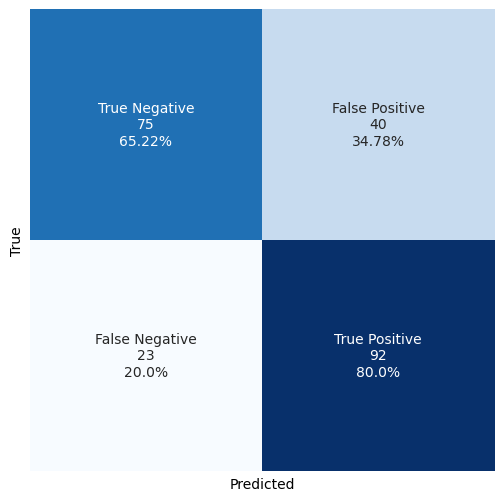

In [127]:
# Confusion Matrix
print_confusion_matrix(test_labels, vgg_prediction_labels)

In [128]:
# Classification report
vgg_classification_report = classification_report(test_labels, vgg_prediction_labels)
print(vgg_classification_report)

              precision    recall  f1-score   support

           0       0.77      0.65      0.70       115
           1       0.70      0.80      0.74       115

    accuracy                           0.73       230
   macro avg       0.73      0.73      0.72       230
weighted avg       0.73      0.73      0.72       230



## AUC-ROC Scores For All Models

In [112]:
initial_auc_roc = roc_auc_score(test_labels, initial_model_prediction_labels)
print("AUC-ROC Score for Initial Model:", initial_auc_roc)

adjusted_auc_roc = roc_auc_score(test_labels, adjusted_model_prediction_labels)
print("AUC-ROC Score for Adjusted Model:", adjusted_auc_roc)

best_hyper_param_auc_roc = roc_auc_score(test_labels, best_hyper_model_prediction_labels)
print("AUC-ROC Score for the Best Hyper-Parameters Model:", best_hyper_param_auc_roc)

vgg_auc_roc = roc_auc_score(test_labels, vgg_prediction_labels)
print("AUC-ROC Score for VGG16 Model:", vgg_auc_roc)

AUC-ROC Score for Initial Model: 0.7173913043478259
AUC-ROC Score for Adjusted Model: 0.7043478260869565
AUC-ROC Score for the Best Hyper-Parameters Model: 0.7260869565217392
AUC-ROC Score for VGG16 Model: 0.7347826086956523
